In [13]:
import cv2
import numpy as np
import pandas as pd
filename = 'E:/pythonfile/recognition/handwritten_numbers/hw_numbers_dataset/'
data = pd.read_csv( filename + 'annotation.csv')

In [104]:
x_data = []#handwritten numbers dataset
for i in range(len(data)):
    img_dir = filename + data.loc[i, 'FileName'] + '.jpg'
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image/255.
    x_data.append(image)

In [105]:
x_data = np.array(x_data).reshape(-1, 32, 64, 1)
x_data = 1-x_data 

In [106]:
train_x =x_data[:60000]
test_x= x_data[60000:80000]
valid_x= x_data[80000:]

In [107]:
train_size = 60000
test_size= 20000
valid_size= 20000

In [108]:
alphabets = u"0123456789.-"
max_str_len = 6 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == 12:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [19]:
y_data = np.ones([len(data), max_str_len]) * -1
y_data_lable = np.ones(len(data)) * -1
for i in range(len(data)):
    y_data[i, 0:len(str(data.loc[i, 'Value']))]= label_to_num(str(data.loc[i, 'Value'])) 
    y_data_lable[i] =str(data.loc[i, 'Value'])

In [20]:
from keras.utils import to_categorical
y_data_one = to_categorical(y_data, num_classes=num_of_characters)

In [21]:
train_y, train_y_lable =y_data_one[:60000],y_data_lable[:60000]
test_y, test_y_lable= y_data_one[60000:80000], y_data_lable[60000:80000]
valid_y, valid_y_lable= y_data_one[80000:], y_data_lable[80000:]

Label:299.19


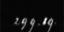

Label:170.4


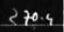

Label:254.4


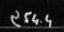

Label:216.0


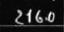

Label:221.9


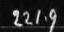

Label:81.1


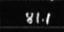

Label:147.4


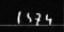

Label:279.2


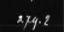

Label:60.2


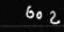

Label:110.1


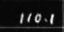

In [109]:
from PIL import Image
from IPython.display import display

def image_see(n):
    image_data = (np.squeeze(x_data[n]) * 255).astype('uint8')
    image = Image.fromarray(image_data, 'L')
    title = f"Label:{data.loc[n,'Value']}"
    print(title)
    display(image)
for id_n in np.random.randint(0, len(data),10):
    image_see(id_n)

In [110]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau 

input_shape = (32, 64, 1)

#CNN
input_img = Input(shape=input_shape, name="image", dtype="float32")
x = Conv2D(32, (3, 3), activation='tanh')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='tanh')(x)
x = MaxPooling2D((2, 2))(x)

#conv_shape = x.get_shape()
#x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2] * conv_shape[3])))(x)
x = Reshape(target_shape=(6, 896))(x)
#x = Dense(64, activation="softmax")(x)

#RNN
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

output = Dense(13, activation="softmax")(x) 

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 64, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 62, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 14, 64)         0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 6, 896)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 6, 256)           

In [111]:
reduce_lr = ReduceLROnPlateau(patience =3, factor = 0.01, weightdecay = 0.05, verbose = 1) 
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=10, restore_best_weights=True)
#train model
history1 = model.fit(train_x, train_y, epochs=50, verbose=1, batch_size=200, 
          validation_data=(valid_x, valid_y), callbacks=[early_stopping, reduce_lr ])

Epoch 1/50
300/300 [==============================] - 73s 244ms/step - loss: 2.4016 - accuracy: 0.2883 - val_loss: 2.1549 - val_accuracy: 0.3334
Epoch 2/50
300/300 [==============================] - 72s 241ms/step - loss: 1.9937 - accuracy: 0.4118 - val_loss: 1.9021 - val_accuracy: 0.4233
Epoch 3/50
300/300 [==============================] - 72s 241ms/step - loss: 1.8577 - accuracy: 0.4277 - val_loss: 1.8273 - val_accuracy: 0.4315
Epoch 4/50
300/300 [==============================] - 71s 238ms/step - loss: 1.7983 - accuracy: 0.4328 - val_loss: 1.7837 - val_accuracy: 0.4337
Epoch 5/50
300/300 [==============================] - 71s 237ms/step - loss: 1.7577 - accuracy: 0.4357 - val_loss: 1.7464 - val_accuracy: 0.4369
Epoch 6/50
300/300 [==============================] - 71s 237ms/step - loss: 1.7272 - accuracy: 0.4381 - val_loss: 1.7160 - val_accuracy: 0.4406
Epoch 7/50
300/300 [==============================] - 73s 242ms/step - loss: 1.7019 - accuracy: 0.4408 - val_loss: 1.6872 - val_ac

In [112]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Model accuracy", "Model loss"))

# Add the first subplot for accuracy
fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['accuracy']) + 1)),
                         y=history1.history['accuracy'], mode='lines',
                         name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['val_accuracy']) + 1)),
                         y=history1.history['val_accuracy'], mode='lines',
                         name='Validation', line=dict(color='orange')), row=1, col=1)

# Add the second subplot for loss
fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['loss']) + 1)),
                         y=history1.history['loss'], mode='lines',
                         name='Train', line=dict(color='blue'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history1.history['val_loss']) + 1)),
                         y=history1.history['val_loss'], mode='lines',
                         name='Validation', line=dict(color='orange'), showlegend=False), row=1, col=2)

fig.update_layout(title="Model Training History",
                  xaxis_title="Epoch",
                  yaxis_title="Value",
                  legend=dict(x=0.85, y=1))

fig.show()

In [23]:
reduce_lr = ReduceLROnPlateau(patience =3, factor = 0.01, weightdecay = 0.05, verbose = 1) 
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=10, restore_best_weights=True)
#train model
history2 = model.fit(train_x, train_y, epochs=100, verbose=1, batch_size=200, 
          validation_data=(valid_x, valid_y), callbacks=[early_stopping, reduce_lr ])

Epoch 1/100
300/300 [==============================] - 86s 286ms/step - loss: 2.2648 - accuracy: 0.2794 - val_loss: 2.0419 - val_accuracy: 0.4283
Epoch 2/100
300/300 [==============================] - 72s 240ms/step - loss: 1.9818 - accuracy: 0.4246 - val_loss: 1.8895 - val_accuracy: 0.4325
Epoch 3/100
300/300 [==============================] - 72s 241ms/step - loss: 1.8854 - accuracy: 0.4318 - val_loss: 1.8181 - val_accuracy: 0.4409
Epoch 4/100
300/300 [==============================] - 72s 240ms/step - loss: 1.8311 - accuracy: 0.4351 - val_loss: 1.7757 - val_accuracy: 0.4390
Epoch 5/100
300/300 [==============================] - 72s 239ms/step - loss: 1.7936 - accuracy: 0.4361 - val_loss: 1.7485 - val_accuracy: 0.4403
Epoch 6/100
300/300 [==============================] - 72s 240ms/step - loss: 1.7645 - accuracy: 0.4362 - val_loss: 1.7270 - val_accuracy: 0.4415
Epoch 7/100
300/300 [==============================] - 72s 239ms/step - loss: 1.7411 - accuracy: 0.4370 - val_loss: 1.7117 -

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=("Model accuracy", "Model loss"))

# Add the first subplot for accuracy
fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['accuracy']) + 1)),
                         y=history2.history['accuracy'], mode='lines',
                         name='Train', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['val_accuracy']) + 1)),
                         y=history2.history['val_accuracy'], mode='lines',
                         name='Validation', line=dict(color='orange')), row=1, col=1)

# Add the second subplot for loss
fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['loss']) + 1)),
                         y=history2.history['loss'], mode='lines',
                         name='Train', line=dict(color='blue'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history2.history['val_loss']) + 1)),
                         y=history2.history['val_loss'], mode='lines',
                         name='Validation', line=dict(color='orange'), showlegend=False), row=1, col=2)

fig.update_layout(title="Model Training History",
                  xaxis_title="Epoch",
                  yaxis_title="Value",
                  legend=dict(x=0.85, y=1))

fig.show()

In [113]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

625/625 [==============================] - 15s 24ms/step - loss: 1.3150 - accuracy: 0.5352
Test Accuracy: 53.52%


In [114]:
test_x.shape

(20000, 32, 64, 1)

In [115]:
#y_pred = model.predict(test_x) valid_x, valid_y
y_pred = model.predict(test_x)
y_pred = np.argmax(y_pred, axis=2)

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(y_pred[i]))

In [116]:
y_true = [str(test_y_lable[i])for i in range(len(test_y_lable))]

In [ ]:
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
#print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
#print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Label:65.2; Predicted:24..3


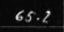

Label:52.3; Predicted:64.7


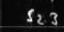

Label:234.9; Predicted:224.8


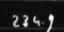

Label:251.7; Predicted:224.2


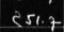

Label:134.1; Predicted:250.0


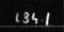

Label:162.1; Predicted:209.5


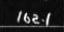

Label:89.7; Predicted:89.7


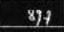

Label:318.1; Predicted:239.1


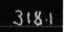

Label:97.5; Predicted:69.0


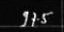

Label:91.7; Predicted:79.7


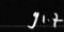

In [118]:
for id_n in np.random.randint(0, len(test_y),10):
    image_data = (np.squeeze(test_x_trn[id_n]) * 255).astype('uint8')
    image = Image.fromarray(image_data, 'L')
    title = f"Label:{y_true[id_n]}; Predicted:{prediction[id_n]}"
    print(title)
    display(image)